In [31]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [32]:
def load_cds_data(path_1y, path_5y, path_10y, path_risk_free, path_term_structure, path_bond_price):
    """Load and standardize all CDS and bond data from CSV files."""
    def standardize_cds_data(path, rename_cols):
        df = pd.read_csv(path)
        df.rename(columns=rename_cols, inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    
    # Load CDS data for each tenor
    df_1y = standardize_cds_data(path_1y, {'Date': 'date'})
    df_5y = standardize_cds_data(path_5y, {'Date': 'date', 'Last Price': 'PX_LAST'})
    df_10y = standardize_cds_data(path_10y, {'Date': 'date'})
    
    # Load risk-free and term structure
    df_risk_free = pd.read_csv(path_risk_free)
    df_term_structure = pd.read_csv(path_term_structure)
    
    # Load and process bond price data
    df_bond_price = pd.read_csv(path_bond_price)
    df_bond_price['date'] = pd.to_datetime(df_bond_price['date'])
    df_bond_price = df_bond_price[['date', 'Time_to_Maturity', 'last_value', 'hazard']]
    df_bond_price.set_index('date', inplace=True)
    
    # Extract start and end dates
    year_end_date = df_bond_price.index[-1]
    year_start_date = df_bond_price.index[0]
    
    return (df_1y, df_5y, df_10y, df_risk_free, df_term_structure, df_bond_price, 
            year_start_date, year_end_date)

# Load data
(df_1y, df_5y, df_10y, df_risk_free, df_term_structure, df_bond_price,
 year_start_date, year_end_date) = load_cds_data(
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CDSdata/UAL_1Y_CDS_prices.csv',
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CDSdata/UAL_5Y_CDS_2014FullData.csv',
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CDSdata/UAL_10Y_CDS_prices.csv',
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CDSdata/risk_free_curve_2015.csv',
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CDSdata/CDS_term_structure_UAL.csv',
    r'/Users/liamrodgers/Desktop/Python/FE800/FE800-Research/CompletedPOC/UAL_hazard_rates.csv'
)

# Assign date ranges (all tenors use same date range in this case)
Y1_end_date, Y5_end_date, Y10_end_date = year_end_date, year_end_date, year_end_date
Y1_start_date, Y5_start_date, Y10_start_date = year_start_date, year_start_date, year_start_date


In [34]:
def Bond_CDS_matching(df1, df2):
    #df1 is the CDS data and df2 is the bond price data
    dates = df1.index.intersection(df2.index)
    df1 = df1.loc[dates]
    return df1

In [35]:
df_1y = Bond_CDS_matching(df_1y, df_bond_price)
df_5y = Bond_CDS_matching(df_5y, df_bond_price) #Data issue
df_10y = Bond_CDS_matching(df_10y, df_bond_price)

In [ ]:
def merge_all_cds_bond_data(df_bond_price, df_1y, df_5y, df_10y):
    """
    Merge bond price data with CDS data for all tenors.
    Handles date matching and sequential merges with appropriate suffixes.
    """
    # Match dates across datasets
    df_1y_matched = Bond_CDS_matching(df_1y, df_bond_price)
    df_5y_matched = Bond_CDS_matching(df_5y, df_bond_price)
    df_10y_matched = Bond_CDS_matching(df_10y, df_bond_price)
    
    # Sequential merges with appropriate suffixes
    df_merged = pd.merge(df_bond_price, df_1y_matched, how='outer',
                         left_index=True, right_index=True, suffixes=('_Bond', '_CDS'))
    df_merged = pd.merge(df_merged, df_5y_matched, how='outer',
                         left_index=True, right_index=True, suffixes=('', '_CDS_5Y'))
    df_merged = pd.merge(df_merged, df_10y_matched, how='outer',a
                         left_index=True, right_index=True, suffixes=('', '_CDS_10Y'))
    df_merged.dropna(inplace=True)
    
    return df_merged

df_CDS_Bond = merge_all_cds_bond_data(df_bond_price, df_1y, df_5y, df_10y)


In [37]:
from datetime import datetime, timedelta
from scipy.optimize import root_scalar

def generate_payment_dates(start_date, end_date, freq_months=3):
    """Return a list of quarterly payment dates from start_date to end_date."""
    pay_dates = []
    current_date = start_date
    while current_date < end_date:
        pay_dates.append(current_date)
        current_date += timedelta(days=(freq_months * 30.44))  # approximate month length
    pay_dates.append(end_date)
    return pay_dates

def get_discount_factor(df_risk_free, payment_date, obs_date):
    tenor = (payment_date - obs_date).days / 365.0
    # Interpolate risk-free rate using nearest available tenors
    match = df_risk_free.loc[np.abs(df_risk_free['tenor'] - tenor).idxmin()]
    rate = match['rate']
    discount = np.exp(-rate * tenor)
    return discount

def bootstrap_hazard(df_cds_series, payment_dates, df_risk_free, obs_date, recovery_rate):
    """
    Piecewise constant hazard rate bootstrapping for survival-based CDS pricing.
    df_cds_series: DataFrame with 'Date' (index) and 'PX_LAST'.
    payment_dates: dates for current tenor (quarterly)
    df_risk_free: risk-free curve DataFrame with 'tenor', 'rate' columns
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    """
    cds_spread = df_cds_series.loc[obs_date, 'PX_LAST'] / 10000  # convert bps to decimal
    f = 0.25  # quarterly payments

    N = len(payment_dates) - 1
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    # Objective: CDS pricing equation root in hazard h for this interval
    def cds_pricer(h):
        Q_local = [1.0]
        for i in range(N):
            dt = (payment_dates[i+1]-payment_dates[i]).days / 365.0
            Q_local.append(Q_local[-1]*np.exp(-h*dt))
        numer = sum([f * discounts[i] * (Q_local[i]-Q_local[i+1]) * (1-recovery_rate) for i in range(N)])
        denom = sum([f * discounts[i] * Q_local[i] for i in range(N)])
        return numer/denom - cds_spread
    # Solve for hazard rate
    sol = root_scalar(cds_pricer, bracket=[1e-6, 2.0], method='bisect')
    h_est = sol.root
    return h_est




In [38]:
def bootstrap_all_hazards(df_1y, df_5y, df_10y, payment_dates, df_risk_free, obs_date, recovery_rate):
    """
    Bootstrap hazard rates for all three tenors.
    
    Args:
        df_1y, df_5y, df_10y: CDS data for each tenor
        payment_dates: payment dates list
        df_risk_free: risk-free curve
        obs_date: observation date
        recovery_rate: assumed recovery rate
    
    Returns: tuple of (h_1y, h_5y, h_10y)
    """
    h_1y = bootstrap_hazard(df_1y, payment_dates, df_risk_free, obs_date, recovery_rate)
    h_5y = bootstrap_hazard(df_5y, payment_dates, df_risk_free, obs_date, recovery_rate)
    h_10y = bootstrap_hazard(df_10y, payment_dates, df_risk_free, obs_date, recovery_rate)
    return h_1y, h_5y, h_10y

# Generate payment dates for each tenor
bond_maturity = datetime(2026, 4, 11)
payment_dates = generate_payment_dates(Y1_start_date, bond_maturity, 3)
h_1y, h_5y, h_10y = bootstrap_all_hazards(df_1y, df_5y, df_10y, payment_dates, df_risk_free, Y1_end_date, 0.4)
y1_bond_hazard = df_bond_price.loc[Y1_end_date, 'hazard']


In [39]:
def construct_survival_curve(payment_dates, hazard_rates, segment_starts):
    """
    Build survival probability Q(0,t) for each payment date using piecewise constant hazard rates.
    payment_dates: sorted list of payment dates (datetime)
    hazard_rates: list of hazard rates per segment (from bootstrapping for [0,1Y], [1Y,5Y], ...)
    segment_starts: list of start dates for each segment
    Returns: list of survival probabilities Q(0,t)
    """
    Q = [1.0]
    for i in range(1, len(payment_dates)):
        t = payment_dates[i]
        # Find the segment index
        for j in range(len(segment_starts)-1, -1, -1):
            if t >= segment_starts[j]:
                h = hazard_rates[j]
                t_prev = payment_dates[i-1]
                dt = (t - t_prev).days / 365.0
                Q.append(Q[-1] * np.exp(-h * dt))
                break
    return Q

def cds_par_spread(payment_dates, Q, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate survival-based par CDS spread for given payment dates and survival curve.
    payment_dates: list of CDS payment dates
    Q: survival probabilities for each payment date
    df_risk_free: DataFrame with risk-free curve
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    f: payment frequency (quarterly=0.25)
    """
    N = len(payment_dates) - 1 
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    numer = sum([f * discounts[i] * (Q[i]-Q[i+1]) * (1-recovery_rate) for i in range(N)])
    denom = sum([f * discounts[i] * Q[i] for i in range(N)])
    par_spread = numer / denom
    return par_spread

def bond_implied_cds(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate bond-implied CDS spread (BCDS) based on fitted bond survival curve Q_bond.
    Same calculation as cds_par_spread, but Q_bond from bond fitting.
    """
    return cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)

def cds_bond_basis(payment_dates, Q_bond, Q_cds, df_risk_free, obs_date, recovery_rate, market_cds_spread, f=0.25):
    """
    Compare bond-implied CDS (BCDS) to actual market CDS for given maturity.
    Returns: Curve Basis (BCDS - market CDS spread)
    """
    bcds = cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)
    curve_basis = bcds - market_cds_spread
    
    print(f"Market {market_cds_spread}\nBond-implied {bcds}\nCurve Basis: {curve_basis}")
    
    return curve_basis


In [40]:
def setup_payment_dates_and_segments(start_1y, end_1y, start_5y, end_5y, start_10y, end_10y,
                                      h_1y, h_5y, h_10y):
    """
    Generate payment dates for all tenors and setup segment configuration.
    
    Returns: dict with 'payment_dates', 'segment_starts', 'hazard_rates', 'all_dates'
    """
    payment_dates_1y = generate_payment_dates(start_1y, end_1y, 3)
    payment_dates_5y = generate_payment_dates(start_5y, end_5y, 3)
    payment_dates_10y = generate_payment_dates(start_10y, end_10y, 3)
    
    segment_starts = [start_1y, start_5y, start_10y]
    hazard_rates = [h_1y, h_5y, h_10y]
    all_payment_dates = payment_dates_1y + payment_dates_5y[1:] + payment_dates_10y[1:]
    
    return {
        'payment_dates_1y': payment_dates_1y,
        'payment_dates_5y': payment_dates_5y,
        'payment_dates_10y': payment_dates_10y,
        'segment_starts': segment_starts,
        'hazard_rates': hazard_rates,
        'all_payment_dates': all_payment_dates
    }

# Setup all tenor configurations
tenor_config = setup_payment_dates_and_segments(
    Y1_start_date, Y1_end_date,
    Y5_start_date, Y5_end_date,
    Y10_start_date, Y10_end_date,
    h_1y, h_5y, h_10y
)

payment_dates_1y = tenor_config['payment_dates_1y']
payment_dates_5y = tenor_config['payment_dates_5y']
payment_dates_10y = tenor_config['payment_dates_10y']
segment_starts = tenor_config['segment_starts']
hazard_rates = tenor_config['hazard_rates']
all_payment_dates = tenor_config['all_payment_dates']
survival_probs = construct_survival_curve(all_payment_dates, hazard_rates, segment_starts)


In [41]:
def calculate_tenor_basis(historical_date, df_cds_bond, payment_dates, market_col, 
                          all_payment_dates, segment_starts, df_risk_free, recovery_rate):
    """
    Calculate basis for a single tenor on a given date.
    
    Args:
        historical_date: valuation date
        df_cds_bond: merged CDS-bond DataFrame
        payment_dates: payment dates for this tenor
        market_col: column name for market CDS price
        all_payment_dates: all payment dates across tenors
        segment_starts: segment start dates for hazard rates
        df_risk_free: risk-free curve
        recovery_rate: assumed recovery rate
    
    Returns: float basis value
    """
    # Get hazard rates for full term structure
    hazards_today = [
        df_cds_bond.loc[historical_date, 'hazard'],
        df_cds_bond.loc[historical_date, 'hazard'],
        df_cds_bond.loc[historical_date, 'hazard']
    ]
    
    # Build survival curve for this date
    Q_full = construct_survival_curve(all_payment_dates, hazards_today, segment_starts)
    Q_tenor = Q_full[:len(payment_dates)]
    
    # Calculate bond-implied CDS
    bcds = bond_implied_cds(payment_dates, Q_tenor, df_risk_free, historical_date, recovery_rate)
    
    # Get market CDS and calculate basis
    market_cds = df_cds_bond.loc[historical_date, market_col] / 10000
    basis = bcds - market_cds
    
    return basis

def calculate_all_basis_across_dates(df_cds_bond, tenor_configs_dict, segment_starts, 
                                     all_payment_dates, df_risk_free, recovery_rate):
    """
    Calculate CDS-Bond basis for all tenors across all historical dates.
    
    Args:
        df_cds_bond: merged CDS and bond DataFrame
        tenor_configs_dict: dict with tenor info {'1Y': (payment_dates, market_col), ...}
        segment_starts: segment start dates
        all_payment_dates: all payment dates
        df_risk_free: risk-free curve
        recovery_rate: assumed recovery rate
    
    Returns: DataFrame with basis for all tenors and dates
    """
    basis_series = []
    
    for historical_date in df_cds_bond.index:
        basis_row = {'Date': historical_date}
        
        for tenor, (payment_dates, market_col) in tenor_configs_dict.items():
            basis = calculate_tenor_basis(
                historical_date, df_cds_bond, payment_dates, market_col,
                all_payment_dates, segment_starts, df_risk_free, recovery_rate
            )
            basis_row[f'CDS_Basis_{tenor}'] = basis
        
        basis_series.append(basis_row)
    
    return pd.DataFrame(basis_series)

# Define tenor configurations (payment dates and market column names)
tenor_configs_dict = {
    '1Y': (payment_dates_1y, 'PX_LAST'),
    '5Y': (payment_dates_5y, 'PX_LAST_CDS_5Y'),
    '10Y': (payment_dates_10y, 'PX_LAST_CDS_10Y')
}

# Calculate all bases
basis_df = calculate_all_basis_across_dates(
    df_CDS_Bond, tenor_configs_dict, segment_starts,
    all_payment_dates, df_risk_free, 0.4
)

# Format the DataFrame
basis_df['Date'] = pd.to_datetime(basis_df['Date'])
for tenor in ['1Y', '5Y', '10Y']:
    basis_df[f'CDS_Basis_{tenor}'] = round(basis_df[f'CDS_Basis_{tenor}'], 3)


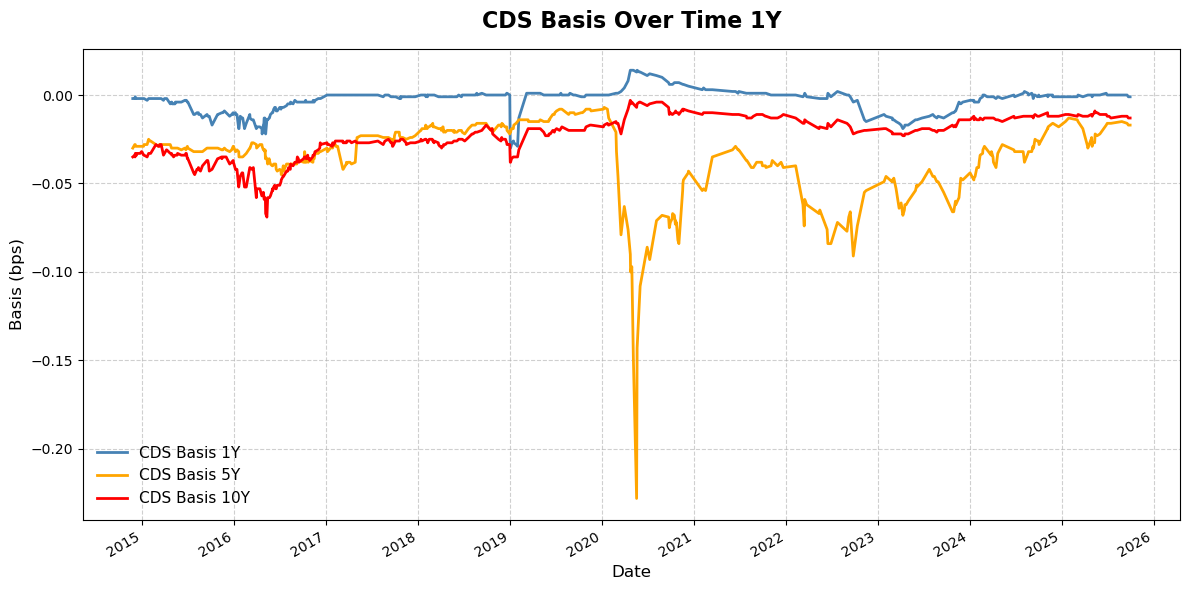

In [42]:
def plot_cds_basis_curves(basis_df, title='CDS Basis Over Time', figsize=(12, 6)):
    """
    Plot CDS basis curves for all tenors.
    
    Args:
        basis_df: DataFrame with 'Date' column and 'CDS_Basis_*Y' columns
        title: plot title
        figsize: figure size (width, height)
    """
    import matplotlib.dates as mdates
    
    tenors_config = [
        ('CDS_Basis_1Y', 'steelblue', 'CDS Basis 1Y'),
        ('CDS_Basis_5Y', 'orange', 'CDS Basis 5Y'),
        ('CDS_Basis_10Y', 'red', 'CDS Basis 10Y')
    ]
    
    plt.figure(figsize=figsize)
    
    for col_name, color, label in tenors_config:
        plt.plot(basis_df['Date'], basis_df[col_name],
                color=color, linewidth=2, label=label)
    
    plt.title(title, fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Basis (bps)', fontsize=12)
    
    # Format date axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()
    
    plt.grid(True, which='major', linestyle='--', alpha=0.6)
    plt.legend(frameon=False, fontsize=11)
    plt.tight_layout()
    plt.show()

plot_cds_basis_curves(basis_df, title='CDS Basis Over Time 1Y')


In [43]:
#The longer tenors are fitting under the 0 basis because we have a flat curve (only one bond). In order to see the full curve we need to get more bonds from UAL
#to truly measure the risk of the longer tenor CDS spread, this is the limitation of the CDS structure that the longer tenor CDSs are typically underpriced